## Imports

In [2]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import os   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping



## Coleta de dados - Stock KO - Coca-cola Company

In [5]:
symbol = 'KO'
start_date = '2010-01-01'
end_date = '2025-04-28'

df = yf.download(symbol, start=start_date, end=end_date)
df = df[['Close']]
df.head()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOG']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Price,Close
Ticker,GOOG
Date,


## Pré-processamento

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Função das janelas temporais
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Divisão dos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3057, 30, 1)
(3057,)
(765, 30, 1)
(765,)


In [9]:
print(X_train.shape[2])

NameError: name 'X_train' is not defined

## Criação e treinamento do modelo

In [6]:
# Estrutura do modelo

model = Sequential()
model.add(LSTM( units=100,
                activation='relu',
              #  return_sequences=True,
                input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

#model.add(LSTM(units=100, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.fit(X_train,
          y_train,
          epochs=50,
          batch_size=32,
          validation_split=0.2,
          callbacks=[early_stopping],
          verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Resultados

In [7]:
# Avaliação
y_pred = model.predict(X_test, verbose=0)
y_test_rescaled = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test), y_test)))[:, 1]
y_pred_rescaled = scaler.inverse_transform(np.column_stack((np.zeros_like(y_pred), y_pred)))[:, 1]

loss = model.evaluate(X_test, y_test, verbose=0)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(root_mean_squared_error(y_test_rescaled, y_pred_rescaled))
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)*100

print(f'Loss: {loss}')
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {(mape):.2f}%")

Loss: 0.00026029490982182324
Mean Absolute Error (MAE): 0.72
Root Mean Squared Error (RMSE): 0.97
Mean Absolute Percentage Error (MAPE): 1.94%


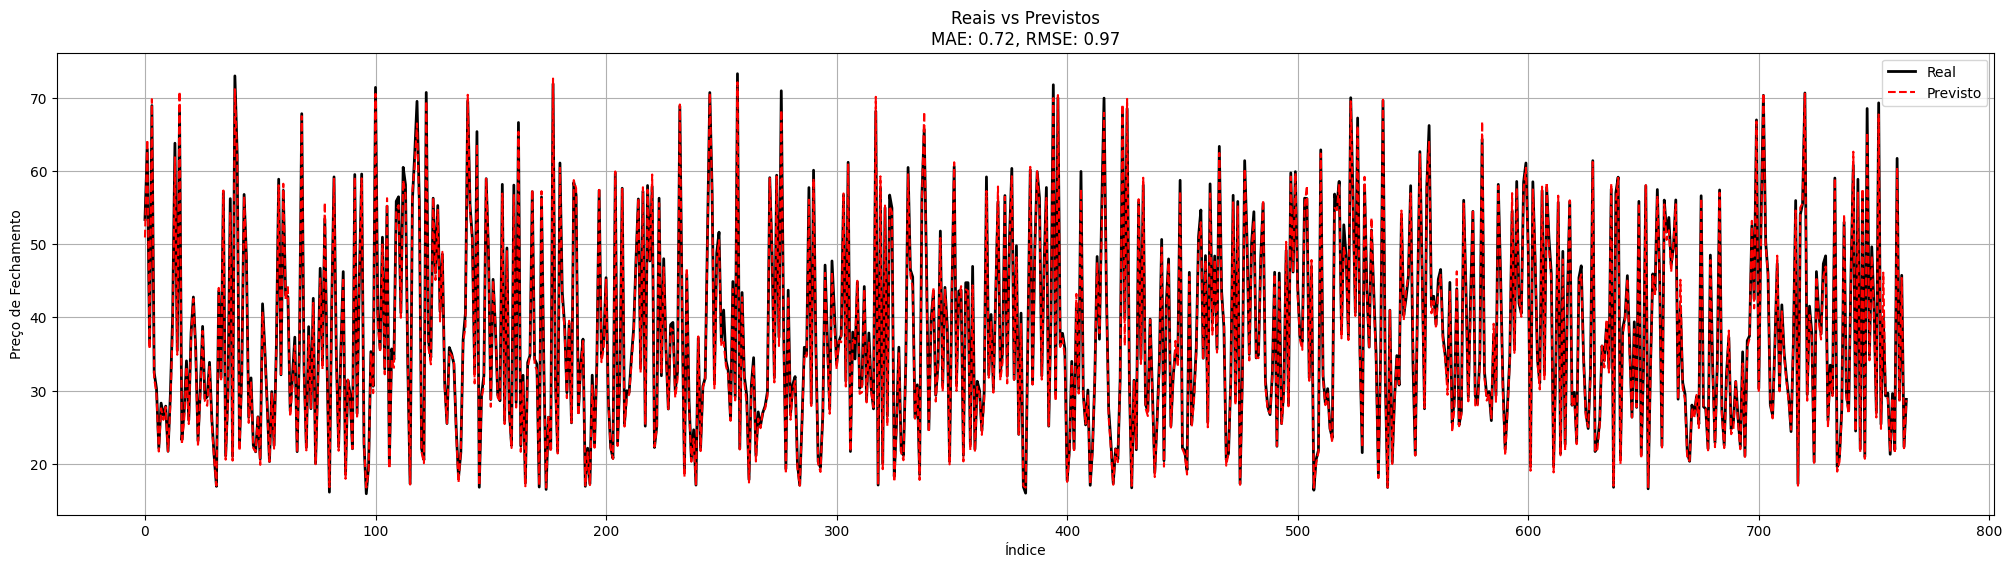

In [8]:
plt.figure(figsize=(25, 6))
plt.plot(y_test_rescaled, label="Real", color='black', linewidth=2)
plt.plot(y_pred_rescaled, label="Previsto", color='red', linestyle='--')
plt.title(f'Reais vs Previstos\nMAE: {mae:.2f}, RMSE: {rmse:.2f}')
plt.xlabel('Índice')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

## Serialização e armazenamento dos artefatos do modelo e do scaler

In [9]:
os.makedirs("Models", exist_ok=True)
model.save(f"Models/modelKO.keras")
joblib.dump(scaler, f'Models/scalerKO.pkl')

['scalerKO.pkl']